All images are available!
Training samples: 16211
Validation samples: 4053
Testing samples: 5067
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 150s 250ms/step - accuracy: 0.4969 - loss: 1.4930 - val_accuracy: 0.5139 - val_loss: 1.4325
Epoch 2/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 74s 141ms/step - accuracy: 0.5123 - loss: 1.4380 - val_accuracy: 0.5174 - val_loss: 1.4171
Epoch 3/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 79s 148ms/step - accuracy: 0.5207 - loss: 1.4131 - val_accuracy: 0.5223 - val_loss: 1.3892
Epoch 4/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 76s 142ms/step - accuracy: 0.5231 - loss: 1.3983 - val_accuracy: 0.5332 - val_loss: 1.3915
Epoch 5/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 78s 147ms/step - accuracy: 0.5256 - loss: 1.3921 - val_accuracy: 0.5236 - val_loss: 1.3781
Epoch 6/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 75s 142ms/step - accuracy: 0.5292 - loss: 1.3857 - val_accuracy: 0.5337 - val_loss: 1.3534
Epoch 7/20
507/507 ━━━━━━━━━━━━━━━━━━━━ 75s 141ms/step - accuracy

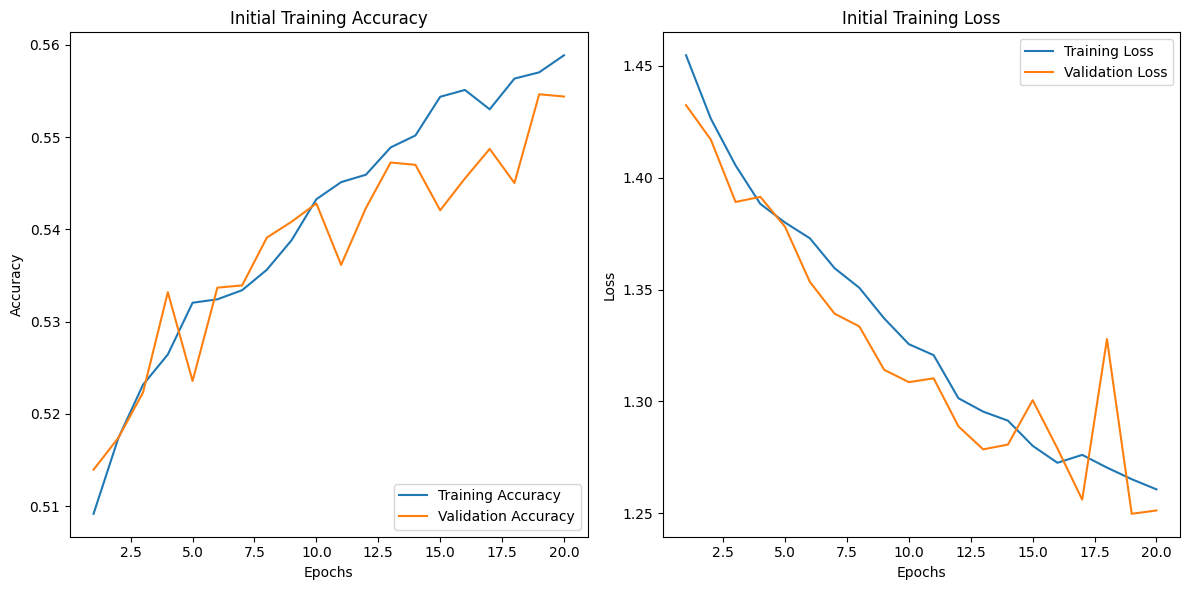

159/159 ━━━━━━━━━━━━━━━━━━━━ 29s 180ms/step - accuracy: 0.5622 - loss: 1.2491
Test Loss: 1.2485
Test Accuracy: 0.5585
Epoch 1/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 266s 413ms/step - accuracy: 0.5178 - loss: 11.7108 - val_accuracy: 0.5083 - val_loss: 109.4908
Epoch 2/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 184s 357ms/step - accuracy: 0.6260 - loss: 1.0891 - val_accuracy: 0.5571 - val_loss: 5.8676
Epoch 3/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 183s 355ms/step - accuracy: 0.6725 - loss: 0.9373 - val_accuracy: 0.6760 - val_loss: 0.9217
Epoch 4/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 183s 355ms/step - accuracy: 0.7038 - loss: 0.8236 - val_accuracy: 0.7002 - val_loss: 0.8723
Epoch 5/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 184s 356ms/step - accuracy: 0.7437 - loss: 0.7135 - val_accuracy: 0.7084 - val_loss: 0.8524
Epoch 6/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 184s 356ms/step - accuracy: 0.7861 - loss: 0.5844 - val_accuracy: 0.7086 - val_loss: 0.8615
Epoch 7/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 183s 355ms/step - accuracy: 0.8382 - loss: 0.45

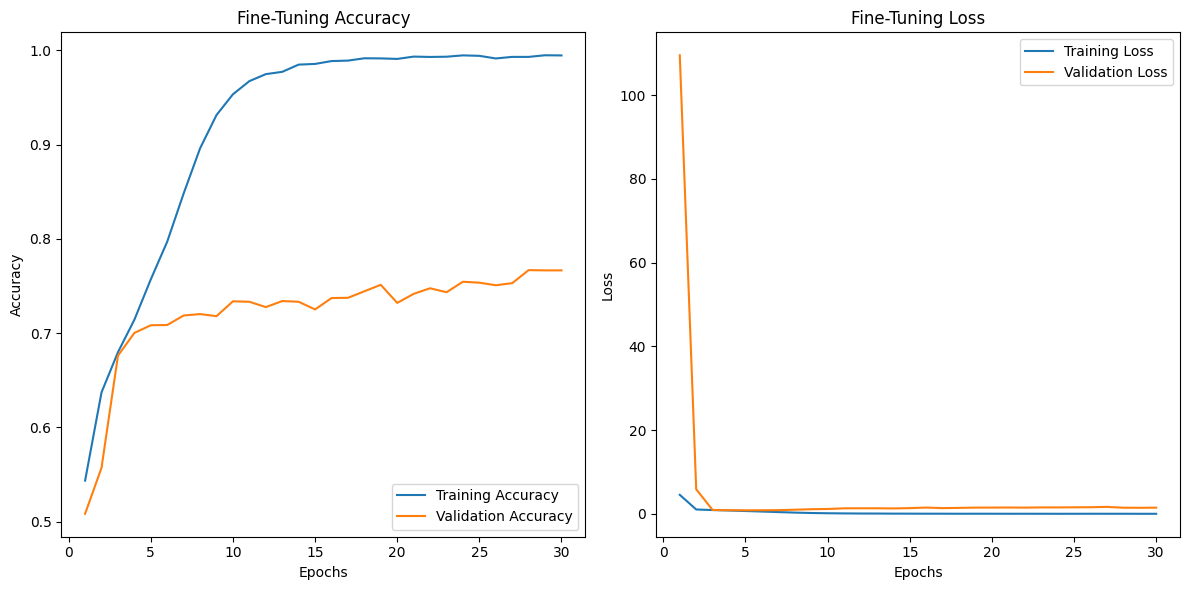

159/159 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - accuracy: 0.7582 - loss: 1.5426
Final Test Loss: 1.5631
Final Test Accuracy after Fine-Tuning: 0.7584
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━

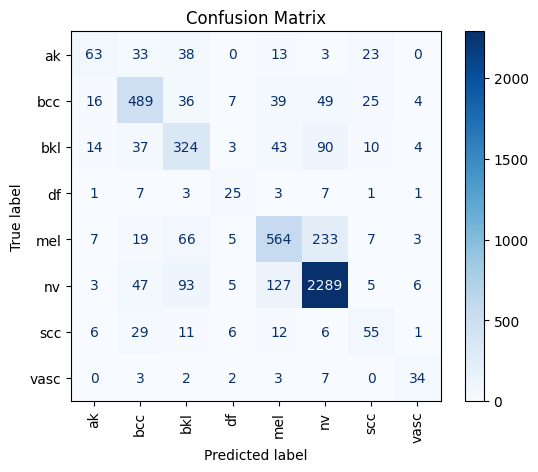

Classification Report:
              precision    recall  f1-score   support

          ak       0.57      0.36      0.45       173
         bcc       0.74      0.74      0.74       665
         bkl       0.57      0.62      0.59       525
          df       0.47      0.52      0.50        48
         mel       0.70      0.62      0.66       904
          nv       0.85      0.89      0.87      2575
         scc       0.44      0.44      0.44       126
        vasc       0.64      0.67      0.65        51

    accuracy                           0.76      5067
   macro avg       0.62      0.61      0.61      5067
weighted avg       0.76      0.76      0.76      5067

Accuracy: 0.76
Precision: 0.76
Recall: 0.76
F1-Score: 0.76


In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# Load the metadata from the Excel file
metadata_path = '/kaggle/input/isic-2019-skin-cancer/data.xlsx'
metadata = pd.read_excel(metadata_path)

# Path to the main image folder
image_folder_path = '/kaggle/input/isic-2019-skin-cancer/Dataset/Dataset'

# Check if all images exist in their respective folders
missing_images = []
for _, row in metadata.iterrows():
    disease_type = row['DiseaseType']  # Folder name
    image_name = row['ImageName']      # File name
    image_path = os.path.join(image_folder_path, disease_type, image_name)
    if not os.path.exists(image_path):
        missing_images.append(image_name)

if missing_images:
    print(f"Missing images: {missing_images}")
else:
    print("All images are available!")

# Add a new column with the full file paths
metadata['filepath'] = metadata.apply(lambda x: os.path.join(image_folder_path, x['DiseaseType'], x['ImageName']), axis=1)

# Encode labels (DiseaseType) into integers
metadata['label_encoded'] = metadata['DiseaseType'].astype('category').cat.codes

# Split data into train+validation and test sets (80% train+val, 20% test)
train_val_df, test_df = train_test_split(
    metadata, 
    test_size=0.2, 
    stratify=metadata['DiseaseType'], 
    random_state=42
)

# Further split train+val into train and validation (80% train, 20% validation)
train_df, val_df = train_test_split(
    train_val_df, 
    test_size=0.2, 
    stratify=train_val_df['DiseaseType'], 
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

# Preprocessing function for images
def preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode JPEG files
    img = tf.image.resize(img, [224, 224])  # Resize to match ResNet50 input size
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img, label

# Prepare TensorFlow datasets
def create_tf_dataset(dataframe, batch_size=32, shuffle=False):
    file_paths = dataframe['filepath'].values
    labels = dataframe['label_encoded'].values
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(preprocess_image)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    return dataset

# Create train, validation, and test datasets
batch_size = 32
train_ds = create_tf_dataset(train_df, batch_size=batch_size, shuffle=True)
val_ds = create_tf_dataset(val_df, batch_size=batch_size)
test_ds = create_tf_dataset(test_df, batch_size=batch_size)

# Define the ResNet50 model
base_model = ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet
    include_top=False,   # Exclude the fully connected layers
    input_shape=(224, 224, 3)  # Input shape for ResNet50
)

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling layer
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dense(512, activation='relu')(x)   # Another fully connected layer
predictions = Dense(len(metadata['label_encoded'].unique()), activation='softmax')(x)  # Output layer

# Create the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',  # Sparse categorical crossentropy for integer labels
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20  # Adjust the number of epochs as needed
)

# Plot training and validation accuracy/loss
def plot_metrics(history, title_prefix=""):
    # Extract metrics
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)
    
    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.show()

# Plot metrics for initial training
plot_metrics(history, title_prefix="Initial Training")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Fine-tune the base model
base_model.trainable = True  # Unfreeze the base model
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Use a lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training with fine-tuning
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30  # Additional epochs for fine-tuning
)

# Plot metrics for fine-tuning
plot_metrics(fine_tune_history, title_prefix="Fine-Tuning")

# Evaluate after fine-tuning
final_test_loss, final_test_accuracy = model.evaluate(test_ds)
print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy after Fine-Tuning: {final_test_accuracy:.4f}")

# Save the model in the Kaggle working directory
model.save('/kaggle/working/resnet50_model.h5')  # Save in HDF5 format

# Evaluation Metrics and Confusion Matrix
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # True labels
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted labels

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix
class_names = metadata['DiseaseType'].astype('category').cat.categories.tolist()
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Additional Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


In [2]:
# Import necessary libraries
from tensorflow.keras.models import load_model  # To load the saved model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load the saved model
model = load_model('/kaggle/working/resnet50_model.h5')  # Load the model
print("Model loaded successfully!")
class_names = ['ak', 'bcc', 'bkl', 'df', 'mel','nv', 'scc', 'vasc']
# Function to preprocess an image
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Resize image to model input size
    img_array = img_to_array(img)  # Convert image to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Path to the test image (update with your actual file path)
image_path = '/kaggle/input/sampletest/WhatsApp Image 2025-02-23 at 16.41.35_6ca4c2e5.jpg'  # Replace with the actual image path

# Preprocess and predict
try:
    test_image = preprocess_image(image_path)
    predictions = model.predict(test_image)
    predicted_index = np.argmax(predictions)  # Get the index of the highest prediction score
    predicted_class = class_names[predicted_index]
    print(f"Predicted Class: {predicted_class}")
except Exception as e:
    print(f"Error in processing or prediction: {e}")

Model loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: bkl
